In [5]:
import dataloader
import torch
import numpy as np
import argparse
import models
import importlib

In [3]:
# Arguments ===================================
parser = argparse.ArgumentParser()

parser.add_argument('--gpu_id', type=int, default=0)
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--config', type=str, default='config.yml')
parser.add_argument('--dataset', type=str, default='cora', choices=['cora', 'citeseer', 'BlogCatalog', 'flickr', 'Polblogs'])
parser.add_argument('--g0_method', type=str, default='random', choices=[
  'random', # randomly distribution of g0
  'bias', # a random class has a 3x higher likelihood of being in g0
  'large_cluster', # a random node and [g0_size] of its neighbors are in g0
  'many_clusters', # 10 random nodes and [g0_size] of their neighbors are in g0
  ])
parser.add_argument('--g0_size', type=float, default=0.1)
parser.add_argument('--attack_method', type=str, default='edge_reconstruction', choices=[
  'sll', # Selective Learnability Lock
  'sll_no_g', # Disable gradient guidance
  'noise', # Noise protection
  'heuristic', # Heuristic protection
  'edge_reconstruction' # Edge Reconstructions
  ])
parser.add_argument('--budget_pct', type=float, default=0.25)
parser.add_argument('--attack_epochs', type=int, default=30)
parser.add_argument('--save_results', type=str, default='Y', choices=['N', 'Y'])
parser.add_argument('--save_graph', type=str, default='N', choices=['N', 'Y'])

args = parser.parse_args("")

if args.gpu_id >= 0:
  device = torch.device(f'cuda:{args.gpu_id}' if torch.cuda.is_available() else 'cpu')
else:
  device = torch.device('cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

import yaml
from yaml import SafeLoader
config = yaml.load(open(args.config), Loader=SafeLoader)[args.dataset]

In [29]:
# Load graph ===================================
graph = dataloader.load_DGL(args.dataset)
feat = graph.ndata['feat'].to(device)
labels = graph.ndata['label'].to(device)
adj = graph.adj().to_dense()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [73]:
def getSimpleGCN() -> models.DenseGCN:
    model = models.DenseGCN(
        in_size=feat.shape[1],
        out_size=labels.max().item()+1,
        hid_size=config['hid_size'],
        lr=config['lr'],
        dropout=config['dropout'],
        weight_decay=config['weight_decay']
    ).to(device)
    return model

def evalModel(model: models.DenseGCN, graph_adj, mask) -> float:
    pred = model(feat, graph_adj).cpu().argmax(dim=1)
    acc = pred[mask] == labels[mask].cpu()
    return (acc.sum() / acc.shape[0]).item()

In [34]:
# Designate g0 ===================================
g0_size = int(args.g0_size * graph.num_nodes())

g0_probs = torch.ones(graph.num_nodes())
g0_probs = g0_probs * (g0_size / g0_probs.sum())
g0_probs.clamp_(0, 1)
g0 = torch.bernoulli(g0_probs).bool()

print(f'G0 size: {g0.sum().item()}')
print(f'G0 pct: {g0.sum().item() / graph.num_nodes():.2%}')

g0 = g0.cpu()
gX = ~g0

G0 size: 249
G0 pct: 9.19%


In [76]:
# Construct a homophilous graph
modified_adj = labels.repeat(labels.shape[0], 1)
modified_adj = (modified_adj == modified_adj.t()).long()

# Invert g0
modified_adj[g0, :][:, g0] = 1 - modified_adj[g0, :][:, g0]

# Remove self-loop
modified_adj.fill_diagonal_(0)
modified_adj = torch.bernoulli(0.1 * modified_adj)

# Train GCN on graph (base)
baselineModel = getSimpleGCN()
baselineModel.fit(feat, modified_adj, labels, 100, mask=graph.ndata['train_mask'] * gX)

# Evaluate accuracy
acc_g0 = evalModel(baselineModel, modified_adj, mask=graph.ndata['test_mask'] * g0)
acc_gX = evalModel(baselineModel, modified_adj, mask=graph.ndata['test_mask'] * gX)
print(acc_g0, acc_gX)

GCN Training: 100%|██████████| 100/100 [00:01<00:00, 65.55it/s, loss=0.19]


0.7179487347602844 0.6963123679161072


In [169]:
def setIndicesTo(tensor: torch.Tensor, indices: torch.Tensor, value):
    tensor[indices, :] = tensor.index_fill(1, indices, value)[indices, :]
    tensor[:, indices] = tensor.index_fill(0, indices, value)[:, indices]

In [189]:
# Construct a homophilous graph
modified_adj = labels.repeat(labels.shape[0], 1)
modified_adj = (modified_adj == modified_adj.t()).long()

# Invert g0
g0_inverted = 1 - modified_adj
g0_inverted[gX, :] = 0
g0_inverted[:, gX] = 0

# Remove g0gX
modified_adj[g0, :] = 0
modified_adj[:, g0] = 0
modified_adj = modified_adj + g0_inverted

# Remove self-loop
modified_adj.fill_diagonal_(0)
# modified_adj = torch.bernoulli(0.01 * modified_adj)

# Train GCN on graph (base)
baselineModel = getSimpleGCN()
baselineModel.fit(feat, modified_adj, labels, 100, mask=graph.ndata['train_mask'] * gX)

# Evaluate accuracy
acc_g0 = evalModel(baselineModel, modified_adj, mask=graph.ndata['test_mask'] * g0)
acc_gX = evalModel(baselineModel, modified_adj, mask=graph.ndata['test_mask'] * gX)
print(acc_g0, acc_gX)

GCN Training: 100%|██████████| 100/100 [00:00<00:00, 279.59it/s, loss=0.07]


0.24358974397182465 1.0


In [172]:
a = torch.rand((4,4))
f = torch.tensor([0, 2])
print(a)
# setIndicesTo(a, f, 10)
a[f, :] = 0
a[:, f] = 0
print(a)

tensor([[0.0016, 0.6581, 0.3407, 0.9375],
        [0.5683, 0.1935, 0.5466, 0.8961],
        [0.6920, 0.3980, 0.3048, 0.5228],
        [0.1042, 0.6412, 0.9652, 0.3789]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1935, 0.0000, 0.8961],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6412, 0.0000, 0.3789]])


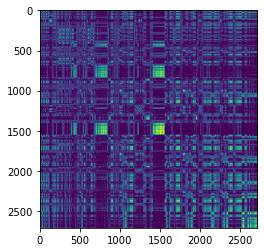

In [188]:
plt.imshow(modified_adj.cpu())

edge_reconstruction


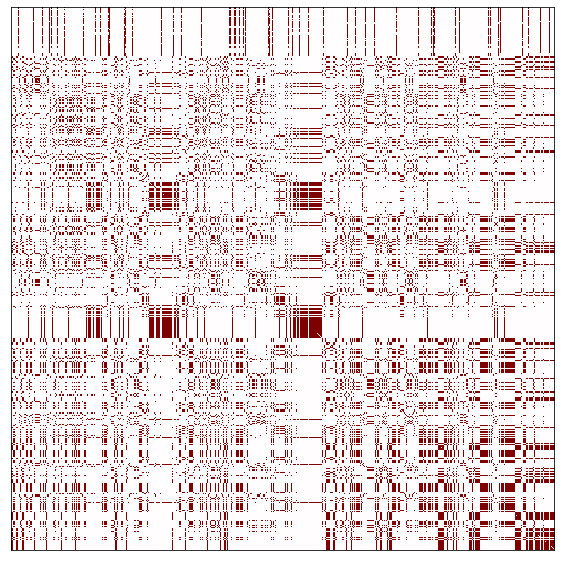

In [186]:
import matplotlib.pyplot as plt
import utils

mat = modified_adj.cpu()
# mat = mat / mat.max()
m1 = torch.zeros_like(mat)
m1[0:g0.sum(), :] = mat[g0, :]
m1[g0.sum():g0.sum() + gX.sum()] = mat[gX]

m2 = torch.zeros_like(mat)
m2[:, 0:g0.sum()] = m1[:, g0]
m2[:, g0.sum():g0.sum() + gX.sum()] = m1[:, gX]

gap = 2
m2[:, g0.sum() - gap: g0.sum() + gap] = -1
m2[g0.sum() - gap: g0.sum() + gap, :] = -1
m2 = utils.make_symmetric(m2)

plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(m1, cmap=plt.cm.seismic, interpolation='none', vmin=-1, vmax=1)
print(args.attack_method)
plt.show()

In [82]:
modified_adj.sum()

tensor(1293., device='cuda:0')